# Generación de Modelos con Clusterización - Mes, Codigo Laboralidad

Este notebook va a generar unos ficheros .csv utilizando la generación de modelos por mes y código de laboralidad. 

Dataset Entrenamiento:
- 1) Dividir anual_data en 12 datasets --> mensual_data(1...12) // 12 meses en 1 año
- 2) Particionar mensual_data por segmento --> mensual_data_seg(1...N) // N es el numero total de segmentos
- 3) Particionar por dias con mismo código de lab --> 


Esquema .csv resultado: ID_SEGMENT | Mes | Cod | HH:MM:SS | REF_ARIMA .... X (Model)

### Lectura de datos

In [1]:
import findspark
import pandas as pd
findspark.init()
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext()
sqlContext = SQLContext(sc)
data_input = sqlContext.read.format("com.databricks.spark.csv").options( header = True, inferSchema = True, sep=';',  line_terminator='\n').load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\input.csv')
anual_data = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\anual_data_2018.csv')

In [2]:
anual_data.printSchema()

root
 |-- ID_SEGMENT: integer (nullable = true)
 |-- COD_LABORALIDAD: integer (nullable = true)
 |-- FECHA: timestamp (nullable = true)
 |-- MES: integer (nullable = true)
 |-- HORA: integer (nullable = true)
 |-- MINUTO: integer (nullable = true)
 |-- CANTIDAD_PREC: double (nullable = true)
 |-- TOTAL_VEHICULOS: integer (nullable = true)
 |-- TOTAL_VEHICULOS_1: integer (nullable = true)
 |-- TOTAL_VEHICULOS_2: integer (nullable = true)
 |-- TOTAL_VEHICULOS_3: integer (nullable = true)
 |-- TOTAL_VEHICULOS_4: integer (nullable = true)
 |-- TOTAL_VEHICULOS_5: integer (nullable = true)
 |-- TOTAL_VEHICULOS_6: integer (nullable = true)
 |-- TOTAL_VEHICULOS_7: integer (nullable = true)
 |-- TOTAL_VEHICULOS_8: integer (nullable = true)
 |-- TOTAL_VEHICULOS_9: integer (nullable = true)
 |-- TOTAL_VEHICULOS_10: integer (nullable = true)
 |-- TOTAL_VEHICULOS_11: integer (nullable = true)
 |-- TOTAL_VEHICULOS_12: integer (nullable = true)
 |-- TOTAL_VEHICULOS_13: integer (nullable = true)
 |-- 

In [3]:
anual_data.count()

701045

In [4]:
df_anual_data= anual_data.toPandas()

##### Deal with NaN values

In [5]:
df_anual_data.isnull().any().sum()
df_anual_data = df_anual_data.dropna(how='any')
df_anual_data["TOTAL_VEHICULOS"].fillna(df_anual_data["TOTAL_VEHICULOS"].mean(),inplace=True)

In [6]:
df_anual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691900 entries, 0 to 701044
Data columns (total 32 columns):
ID_SEGMENT            691900 non-null float64
COD_LABORALIDAD       691900 non-null float64
FECHA                 691900 non-null datetime64[ns]
MES                   691900 non-null float64
HORA                  691900 non-null float64
MINUTO                691900 non-null float64
CANTIDAD_PREC         691900 non-null float64
TOTAL_VEHICULOS       691900 non-null float64
TOTAL_VEHICULOS_1     691900 non-null float64
TOTAL_VEHICULOS_2     691900 non-null float64
TOTAL_VEHICULOS_3     691900 non-null float64
TOTAL_VEHICULOS_4     691900 non-null float64
TOTAL_VEHICULOS_5     691900 non-null float64
TOTAL_VEHICULOS_6     691900 non-null float64
TOTAL_VEHICULOS_7     691900 non-null float64
TOTAL_VEHICULOS_8     691900 non-null float64
TOTAL_VEHICULOS_9     691900 non-null float64
TOTAL_VEHICULOS_10    691900 non-null float64
TOTAL_VEHICULOS_11    691900 non-null float64
TOTAL_VE

In [7]:
from datetime import datetime, timedelta 
df_anual_data['TIME'] = pd.to_datetime(df_anual_data['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))
df_anual_data.TIME[:5]

0    00:00:00
1    00:00:00
2    00:00:00
3    00:00:00
4    00:00:00
Name: TIME, dtype: object

### Lectura de Dataset de testing

In [8]:
enero19 = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\enero19.csv')
febrero19 = sqlContext.read.format("com.databricks.spark.csv").options( header = True, sep=';',  line_terminator='\n').schema(data_input.schema).load( path='C:\\Users\\yolan\\Documents\\indra\\dataanalytics.predictive\\data\\febrero19.csv')
df_enero19 = enero19.toPandas()
df_febrero19 = febrero19.toPandas()

##### Deal with NaN values

In [9]:
df_enero19.isnull().any().sum()
df_febrero19.isnull().any().sum()
df_febrero19 = df_febrero19.dropna(how='any')
df_enero19 = df_enero19.dropna(how='any')
df_enero19["TOTAL_VEHICULOS"].fillna(df_enero19["TOTAL_VEHICULOS"].mean(),inplace=True)
df_febrero19["TOTAL_VEHICULOS"].fillna(df_febrero19["TOTAL_VEHICULOS"].mean(),inplace=True)

df_enero19['TIME'] = pd.to_datetime(df_enero19['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))
df_febrero19['TIME'] = pd.to_datetime(df_febrero19['FECHA']).map(lambda x: x.strftime('%H:%M:%S'))

In [10]:
df_enero19.info()
df_febrero19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58830 entries, 0 to 59539
Data columns (total 33 columns):
ID_SEGMENT            58830 non-null float64
COD_LABORALIDAD       58830 non-null float64
FECHA                 58830 non-null datetime64[ns]
MES                   58830 non-null float64
HORA                  58830 non-null float64
MINUTO                58830 non-null float64
CANTIDAD_PREC         58830 non-null float64
TOTAL_VEHICULOS       58830 non-null float64
TOTAL_VEHICULOS_1     58830 non-null float64
TOTAL_VEHICULOS_2     58830 non-null float64
TOTAL_VEHICULOS_3     58830 non-null float64
TOTAL_VEHICULOS_4     58830 non-null float64
TOTAL_VEHICULOS_5     58830 non-null float64
TOTAL_VEHICULOS_6     58830 non-null float64
TOTAL_VEHICULOS_7     58830 non-null float64
TOTAL_VEHICULOS_8     58830 non-null float64
TOTAL_VEHICULOS_9     58830 non-null float64
TOTAL_VEHICULOS_10    58830 non-null float64
TOTAL_VEHICULOS_11    58830 non-null float64
TOTAL_VEHICULOS_12    58830 n

### Generate Training Datasets

In [11]:
months = df_anual_data.FECHA.dt.month.unique()
segments = df_anual_data.ID_SEGMENT.unique()
codes = df_anual_data.COD_LABORALIDAD.unique()

print("Months " + str(months))
print("Segments " + str(segments))
print("Codes " + str(codes))

total_trainsets = len(months) * len(segments) * len(codes)
print("Number of training sets: " + str(total_trainsets))

Months [ 1  2  3  4  5  6  7  8  9 10 11 12]
Segments [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Codes [2. 1. 3. 4. 5. 6. 7.]
Number of training sets: 1680


In [12]:
rows_per_day=int(((60/15)*24))

training_sets = {'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD':[], 'TRAINING_SET':[] }
for seg_id in segments: # 1) Particionar anual_data por segmento
    df_seg = df_anual_data.loc[df_anual_data.ID_SEGMENT==seg_id]
    for month_i in df_seg.FECHA.dt.month.unique(): # 2) Dividir mensual_data en 12 datasets 
        df_month_seg = df_seg.loc[df_seg.FECHA.dt.month==month_i]
        for code_i in df_month_seg.COD_LABORALIDAD.unique(): # 3) Particionar por dias con mismo código de lab
            df_month_seg_code = df_month_seg.loc[df_month_seg.COD_LABORALIDAD==code_i]
                
            # Fill training_sets dictionary
            
            training_sets['ID_SEGMENT'].append(seg_id)
            training_sets['MES'].append(month_i)
            training_sets['COD_LABORALIDAD'].append(code_i)
            training_sets['TRAINING_SET'].append(df_month_seg_code)
            

In [13]:
for row in range(0,total_trainsets):
    print("----------------------------> TRAINING SET NUMBER: " + str(row))
    print("SEGMENTO " + str(training_sets['ID_SEGMENT'][row]))
    print("MES " + str(training_sets['MES'][row]))
    print("COD_LABORALIDAD " + str(training_sets['COD_LABORALIDAD'][row]))
    print("DAYS IN TRAINING_SET: " + str(training_sets['TRAINING_SET'][row].FECHA.dt.day.unique()))

----------------------------> TRAINING SET NUMBER: 0
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 1 29  8 15 22]
----------------------------> TRAINING SET NUMBER: 1
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [28  7 14 21]
----------------------------> TRAINING SET NUMBER: 2
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [30  2  9 16 23  1]
----------------------------> TRAINING SET NUMBER: 3
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [31  3 10 17 24]
----------------------------> TRAINING SET NUMBER: 4
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 5
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 6
SEGMENTO 1.0
MES 1
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 7
SEGMENTO 1.0
MES 2
COD_LABORALIDAD 5.0


SEGMENTO 2.0
MES 8
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 137
SEGMENTO 2.0
MES 8
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 138
SEGMENTO 2.0
MES 8
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 139
SEGMENTO 2.0
MES 8
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 140
SEGMENTO 2.0
MES 9
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 141
SEGMENTO 2.0
MES 9
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 142
SEGMENTO 2.0
MES 9
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 143
SEGMENTO 2.0
MES 9
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
---------

SEGMENTO 4.0
MES 6
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 1 22 29  8 15]
----------------------------> TRAINING SET NUMBER: 288
SEGMENTO 4.0
MES 6
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [20 27  6 13]
----------------------------> TRAINING SET NUMBER: 289
SEGMENTO 4.0
MES 6
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [21 28  7 14]
----------------------------> TRAINING SET NUMBER: 290
SEGMENTO 4.0
MES 6
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [23 30  2  9 16]
----------------------------> TRAINING SET NUMBER: 291
SEGMENTO 4.0
MES 6
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [24  3 10 17]
----------------------------> TRAINING SET NUMBER: 292
SEGMENTO 4.0
MES 6
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [25  4 11 18]
----------------------------> TRAINING SET NUMBER: 293
SEGMENTO 4.0
MES 6
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [26  5 12 19]
----------------------------> TRAINING SET NUMBER: 294
SEGMENTO 4.0
MES 7
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
------

DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> TRAINING SET NUMBER: 437
SEGMENTO 6.0
MES 3
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 438
SEGMENTO 6.0
MES 3
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 439
SEGMENTO 6.0
MES 3
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 440
SEGMENTO 6.0
MES 3
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 441
SEGMENTO 6.0
MES 4
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 442
SEGMENTO 6.0
MES 4
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 443
SEGMENTO 6.0
MES 4
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NU

DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 579
SEGMENTO 7.0
MES 11
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 580
SEGMENTO 7.0
MES 11
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 581
SEGMENTO 7.0
MES 12
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1 29  8 15 22]
----------------------------> TRAINING SET NUMBER: 582
SEGMENTO 7.0
MES 12
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [30  2  9 16 23]
----------------------------> TRAINING SET NUMBER: 583
SEGMENTO 7.0
MES 12
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [31  3 10 17 24]
----------------------------> TRAINING SET NUMBER: 584
SEGMENTO 7.0
MES 12
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 585
SEGMENTO 7.0
MES 12
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING

DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 726
SEGMENTO 9.0
MES 8
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 727
SEGMENTO 9.0
MES 8
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 728
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 729
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 730
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 731
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 732
SEGMENTO 9.0
MES 9
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBE

DAYS IN TRAINING_SET: [ 9 16 23 30  2]
----------------------------> TRAINING SET NUMBER: 874
SEGMENTO 11.0
MES 5
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [10 17 24 31  3]
----------------------------> TRAINING SET NUMBER: 875
SEGMENTO 11.0
MES 6
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 1 22 29  8 15]
----------------------------> TRAINING SET NUMBER: 876
SEGMENTO 11.0
MES 6
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [20 27  6 13]
----------------------------> TRAINING SET NUMBER: 877
SEGMENTO 11.0
MES 6
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [21 28  7 14]
----------------------------> TRAINING SET NUMBER: 878
SEGMENTO 11.0
MES 6
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [23 30  2  9 16]
----------------------------> TRAINING SET NUMBER: 879
SEGMENTO 11.0
MES 6
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [24  3 10 17]
----------------------------> TRAINING SET NUMBER: 880
SEGMENTO 11.0
MES 6
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [25  4 11 18]
----------------------------> TRAIN

DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1022
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 1023
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 1024
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> TRAINING SET NUMBER: 1025
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1026
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1027
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1028
SEGMENTO 13.0
MES 3
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> T

DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 1164
SEGMENTO 14.0
MES 11
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 1165
SEGMENTO 14.0
MES 11
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1166
SEGMENTO 14.0
MES 11
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1167
SEGMENTO 14.0
MES 11
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1168
SEGMENTO 14.0
MES 11
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1169
SEGMENTO 14.0
MES 12
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 1 29  8 15 22]
----------------------------> TRAINING SET NUMBER: 1170
SEGMENTO 14.0
MES 12
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [30  2  9 16 23]
------------------------

DAYS IN TRAINING_SET: [25  4 11 18]
----------------------------> TRAINING SET NUMBER: 1301
SEGMENTO 16.0
MES 6
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [26  5 12 19]
----------------------------> TRAINING SET NUMBER: 1302
SEGMENTO 16.0
MES 7
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 1303
SEGMENTO 16.0
MES 7
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 1304
SEGMENTO 16.0
MES 7
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> TRAINING SET NUMBER: 1305
SEGMENTO 16.0
MES 7
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1306
SEGMENTO 16.0
MES 7
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1307
SEGMENTO 16.0
MES 7
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> T

DAYS IN TRAINING_SET: [20 27  6 13]
----------------------------> TRAINING SET NUMBER: 1465
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [21 28  7 14]
----------------------------> TRAINING SET NUMBER: 1466
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [23 30  2  9 16]
----------------------------> TRAINING SET NUMBER: 1467
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [24  3 10 17]
----------------------------> TRAINING SET NUMBER: 1468
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [25  4 11 18]
----------------------------> TRAINING SET NUMBER: 1469
SEGMENTO 18.0
MES 6
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [26  5 12 19]
----------------------------> TRAINING SET NUMBER: 1470
SEGMENTO 18.0
MES 7
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 1471
SEGMENTO 18.0
MES 7
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> T

DAYS IN TRAINING_SET: [ 3 10 17 24]
----------------------------> TRAINING SET NUMBER: 1606
SEGMENTO 20.0
MES 2
COD_LABORALIDAD 1.0
DAYS IN TRAINING_SET: [ 4 11 18 25]
----------------------------> TRAINING SET NUMBER: 1607
SEGMENTO 20.0
MES 2
COD_LABORALIDAD 2.0
DAYS IN TRAINING_SET: [ 5 12 19 26]
----------------------------> TRAINING SET NUMBER: 1608
SEGMENTO 20.0
MES 2
COD_LABORALIDAD 3.0
DAYS IN TRAINING_SET: [ 6 13 20 27]
----------------------------> TRAINING SET NUMBER: 1609
SEGMENTO 20.0
MES 2
COD_LABORALIDAD 4.0
DAYS IN TRAINING_SET: [ 7 14 21 28]
----------------------------> TRAINING SET NUMBER: 1610
SEGMENTO 20.0
MES 3
COD_LABORALIDAD 5.0
DAYS IN TRAINING_SET: [ 1  8 15 22 29]
----------------------------> TRAINING SET NUMBER: 1611
SEGMENTO 20.0
MES 3
COD_LABORALIDAD 6.0
DAYS IN TRAINING_SET: [ 2  9 16 23 30]
----------------------------> TRAINING SET NUMBER: 1612
SEGMENTO 20.0
MES 3
COD_LABORALIDAD 7.0
DAYS IN TRAINING_SET: [ 3 10 17 24 31]
----------------------------> T

In [14]:
df_training_sets = pd.DataFrame(training_sets)
df_training_sets.info()
df_training_sets['TRAINING_SET'].iloc[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 4 columns):
ID_SEGMENT         1680 non-null float64
MES                1680 non-null int64
COD_LABORALIDAD    1680 non-null float64
TRAINING_SET       1680 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 52.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 49280
Data columns (total 33 columns):
ID_SEGMENT            480 non-null float64
COD_LABORALIDAD       480 non-null float64
FECHA                 480 non-null datetime64[ns]
MES                   480 non-null float64
HORA                  480 non-null float64
MINUTO                480 non-null float64
CANTIDAD_PREC         480 non-null float64
TOTAL_VEHICULOS       480 non-null float64
TOTAL_VEHICULOS_1     480 non-null float64
TOTAL_VEHICULOS_2     480 non-null float64
TOTAL_VEHICULOS_3     480 non-null float64
TOTAL_VEHICULOS_4     480 non-null float64
TOTAL_VEHICULOS_5     480 non-null float

### Model training

#### Start training with the MONTHS 1 y 2 (Months in testing set)

In [15]:
# select in testing segment 1
df_enero19_seg1 = df_enero19.loc[df_enero19.ID_SEGMENT==1]
df_febrero19_seg1 = df_febrero19.loc[df_febrero19.ID_SEGMENT==1]

In [16]:
rows_per_day=int(((60/15)*24))
rows_dataset =len(df_training_sets['TRAINING_SET'].iloc[0]['FECHA'].unique())
rows_dataset/rows_per_day

5.0

In [17]:
dfaux = df_training_sets.loc[(df_training_sets.MES==2)&(df_training_sets.ID_SEGMENT==2)&(df_training_sets.COD_LABORALIDAD==2)]['TRAINING_SET'].iloc[0]
dfaux.TOTAL_VEHICULOS

67222      94.0
67242     107.0
67262      70.0
67282      60.0
67302      28.0
67322      29.0
67342      17.0
67362      24.0
67382      33.0
67402      34.0
67422      15.0
67442      16.0
67462      12.0
67482      19.0
67502      32.0
67522      25.0
67542      18.0
67562      13.0
67582      24.0
67602      25.0
67622      45.0
67642      55.0
67662      63.0
67682      61.0
67702      93.0
67722      86.0
67742      93.0
67762     173.0
67782     197.0
67802     257.0
          ...  
108862    534.0
108882    537.0
108902    531.0
108922    571.0
108942    598.0
108962    534.0
108982    653.0
109002    637.0
109022    610.0
109042    578.0
109062    520.0
109082    495.0
109102    553.0
109122    437.0
109142    412.0
109162    473.0
109182    389.0
109202    307.0
109222    286.0
109242    269.0
109262    233.0
109282    185.0
109302    224.0
109322    209.0
109342    164.0
109362    170.0
109382    135.0
109402    160.0
109422    132.0
109442    136.0
Name: TOTAL_VEHICULOS, L

In [18]:
df_training_sets['ID_SEGMENT'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

In [19]:
months=[1,2]
segments=[1]
import matplotlib.pyplot as plt

for month_i in months: # Months 1 y 2
    for seg_id in segments: # Segment 1
        for code_i in df_month_seg.COD_LABORALIDAD.unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==month_i)&(df_training_sets.ID_SEGMENT==seg_id)&(df_training_sets.COD_LABORALIDAD==code_i)]['TRAINING_SET'].iloc[0]
            # Plot training days
            plt.figure(figsize=(60,28))
            plt.title('TRAINING DATA SET FOR CODE: ' + str(code_i) + ' MONTH: ' + str(month_i) + ' SEGMENTO ID ' + str(seg_id) ,  fontsize=30)
            i=0
            for niter in range(int(len(df_train.index)/96)):
                plt.plot(df_train.TIME[i:i+96], df_train.TOTAL_VEHICULOS[i:i+96], marker='', label=str("Model - Code " + str(code_i) + ' month: ' + str(month_i) + ' segment: ' + str(seg_id)))
                i=i+96
plt.legend(loc='best',  fontsize=5)
plt.show()

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

<Figure size 6000x2800 with 1 Axes>

### EXPONENTIAL SMOOTHING

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing

In [1]:
months=[1]
segments=[1]
codes=[4]
import matplotlib.pyplot as plt
import numpy as np

for seg_id in segments: # Segment 1
    for month_i in months: # Months 1 y 2
        for code_i in codes:#in df_training_sets['COD_LABORALIDAD'].unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==month_i)&(df_training_sets.ID_SEGMENT==seg_id)&(df_training_sets.COD_LABORALIDAD==code_i)]['TRAINING_SET'].iloc[0]
            index_values = df_train.index

            # Train arima models
            training_values = df_train.TOTAL_VEHICULOS
            exp_fit1 = ExponentialSmoothing(np.asarray(training_values), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.5)
            plt.figure(figsize=(40,40))
            plt.title('CARACTERISTIC CURVE FOR CODE: ' + str(code_i) + ' MONTH: ' + str(month_i) + ' SEGMENTO ID ' + str(seg_id) ,  fontsize=30)
            y_hat_avg = exp_fit1.forecast(steps=96)
            step=0
            for i in range(0,4):
                plt.plot(df_train.TIME[step:step+96], df_train.TOTAL_VEHICULOS[step:step+96], marker='', label=str("Real curve for " + str(code_i) + ' month: ' + str(month_i) + ' segment: ' + str(seg_id)), color='grey', linewidth=1, alpha=0.5)
                step=step+96
            plt.plot(df_train.TIME[0:96], y_hat_avg, marker='', label='ExpSmooth curve for :  Code ' + str(code_i) + ' month: ' + str(month_i) + ' segment: ' + str(seg_id))
plt.legend(loc='best')
plt.show()

NameError: name 'df_training_sets' is not defined

### Generate model_data.csv with the generalized curve extracted with each model

Estructura de model_data.csv

- MODELO: Modelo con el que se ha calculado la curva patron REF_ARIMA .... X (Model)
- ID_SEGMENT: Segmento id para el que se ha calculado el modelo
- MES: Mes para el que se ha calculado el modelo
- COD_LABORALIDAD: Codigo de laboralidad para el cual se ha calculado el modelo
- TIME: El timestamp con formato HH:MM:SS (diario)
- TOTAL_VEHICULOS: Valor asociado a un time dentro del dia patron con cod_laboralidad X, segmento Y, mes Z


In [22]:
exp_model_data_dict = {'TIME':[], 'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD': [], 'TOTAL_VEHICULOS': []}

In [26]:
import matplotlib.pyplot as plt
import numpy as np
MODEL_NAME =  'ExponentialSmoothing'

#segments=[1]
#months=[2,3,4,5,6]
#codes=[2]

processed_segs=[]
processed_months=[]
processed_codes=[]

save_iter=0
reach_checkpoint=1
i_part=0

for month_i in df_training_sets['MES'].unique(): # Months 
    index_values=None
    training_values=None
    y_hat_avg=None
    exp_fit1=None
    df_train=None
    # update iterations
    save_iter=save_iter+1
            
    for seg_id in df_training_sets['ID_SEGMENT'].unique(): # Segment
        for code_i in df_training_sets['COD_LABORALIDAD'].unique(): # All codes present
            df_train = df_training_sets.loc[(df_training_sets.MES==int(month_i))&(df_training_sets.ID_SEGMENT==int(seg_id))&(df_training_sets.COD_LABORALIDAD==int(code_i))]['TRAINING_SET'].iloc[0]

            # Train exponential smoothing models
            training_values = df_train.TOTAL_VEHICULOS
            exp_fit1 = ExponentialSmoothing(np.asarray(training_values), seasonal_periods=96, seasonal='add',).fit(smoothing_level=0.5)
            y_hat_avg = exp_fit1.forecast(steps=96)
            
            # Fill model_data_dict with the model curve
            exp_model_data_dict['ID_SEGMENT'].extend([int(seg_id)]*96)
            exp_model_data_dict['MES'].extend([int(month_i)]*96)
            exp_model_data_dict['COD_LABORALIDAD'].extend([int(code_i)]*96)
            exp_model_data_dict['TIME'].extend(df_train.TIME[0:96])
            exp_model_data_dict['TOTAL_VEHICULOS'].extend(y_hat_avg.astype(int))
            

            
            # checkpoint info
            processed_segs.append(int(seg_id))
            processed_months.append(int(month_i))
            processed_codes.append(int(code_i))

    if save_iter >= reach_checkpoint:
        df_exp_model = pd.DataFrame(exp_model_data_dict)
        df_exp_model.to_csv(str(i_part) + "_ExponentialSmoothing" + ".csv", sep=";", index=False)

        print("Saving results.... File part: "+ str(i_part)  )
        print("Processed segments: " +  str(set(processed_segs)))
        print("Processed months: " +  str(set(processed_months)))
        print("Processed codes: " +  str(set(processed_codes)))
        i_part=i_part+1

        # clean variables
        df_exp_model = None
        save_iter=0
        exp_model_data_dict = {'TIME':[], 'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD': [], 'TOTAL_VEHICULOS': []}

Saving results.... File part: 0
Processed segments: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Processed months: {1}
Processed codes: {1, 2, 3, 4, 5, 6, 7}
Saving results.... File part: 1
Processed segments: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Processed months: {1, 2}
Processed codes: {1, 2, 3, 4, 5, 6, 7}
Saving results.... File part: 2
Processed segments: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Processed months: {1, 2, 3}
Processed codes: {1, 2, 3, 4, 5, 6, 7}
Saving results.... File part: 3
Processed segments: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Processed months: {1, 2, 3, 4}
Processed codes: {1, 2, 3, 4, 5, 6, 7}
Saving results.... File part: 4
Processed segments: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
Processed months: {1, 2, 3, 4, 5}
Processed codes: {1, 2, 3, 4, 5, 6, 7}
Saving results.... File part: 5
Processed seg

In [ ]:
df_exp_model = None
df_exp_model = pd.DataFrame(exp_model_data_dict)
df_exp_model.info()

In [ ]:
df_exp_model.to_csv("ExponentialSmoothing_seg1_m1_2.csv", index=False)

### Check white noise signal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

arima_model_data_dict = {'ID_SEGMENT':[], 'MES':[], 'COD_LABORALIDAD': [], 'TIME':[], 'TOTAL_VEHICULOS': []}

MODEL_NAME =  'ARIMA'
df_avg_totalVehicles = df_exp_model.groupBy(['ID_SEGMENT','MES','COD_LABORALIDAD']).avg('TOTAL_VEHICULOS')

for seg_id in df_exp_model['ID_SEGMENT'].unique(): # Segment
    for month_i in df_exp_model['MES'].unique(): # Months 
        for code_i in df_exp_model['COD_LABORALIDAD'].unique(): # All codes present
            mean = df_avg_totalVehicles.loc[(df_avg_totalVehicles.MES==month_i)&(df_avg_totalVehicles.ID_SEGMENT==seg_id)&(df_avg_totalVehicles.COD_LABORALIDAD==code_i)]['avg(TOTAL_VEHICULOS)'].iloc[0]
            noise = np.random.poisson(target_dims)
            df_train = df_exp_model.loc[(df_exp_model.MES==month_i)&(df_exp_model.ID_SEGMENT==seg_id)&(df_exp_model.COD_LABORALIDAD==code_i)]
            index_values = df_train.TIME
            noise = np.random.poisson(mean, len(index_values))
            preds = df_train.TOTAL_VEHICULOS + noise
            
            # Fill model_data_dict with the model curve
            arima_model_data_dict['ID_SEGMENT'].extend([int(seg_id)]*len(index_values))
            arima_model_data_dict['MES'].extend([int(month_i)]*len(index_values))
            arima_model_data_dict['COD_LABORALIDAD'].extend([int(code_i)]*len(index_values))
            arima_model_data_dict['TIME'].extend(index_values)
            arima_model_data_dict['TOTAL_VEHICULOS'].extend(preds.astype(int))

In [ ]:
df_arima_model = pd.DataFrame(arima_model_data_dict)
df_arima_model.info()

In [ ]:
df_arima_model.to_csv("Arima.csv", index=False)

In [ ]:
### Model Evaluation - Plot testing and model

In [ ]:
preds_ar = df_arima_model.loc[(df_arima_model.MES==1)&(df_arima_model.ID_SEGMENT==1)&(df_arima_model.COD_LABORALIDAD==1)]['TOTAL_VEHICULOS']
preds_exp = df_exp_model.loc[(df_exp_model.MES==1)&(df_exp_model.ID_SEGMENT==1)&(df_exp_model.COD_LABORALIDAD==1)]['TOTAL_VEHICULOS']
test_enero19 = df_enero19_seg1.loc[df_enero19_seg1.COD_LABORALIDAD==1]['TOTAL_VEHICULOS']
real = df_anual_data.loc[(df_anual_data.MES==1)&(df_anual_data.ID_SEGMENT==1)&(df_anual_data.COD_LABORALIDAD==1)]
index_values = df_enero19_seg1.loc[df_enero19_seg1.COD_LABORALIDAD==1].index

plt.figure(figsize=(40,18))
for i in range(real.size)
    plt.plot(index_values, real.iloc[i]['TOTAL_VEHICULOS'], label='Real')
    
plt.plot(index_values, preds_ar, label='arima')
plt.plot(index_values, preds_exp, label='exponential')
plt.plot(index_values, test_enero19, label='test')
plt.legend(loc='best')
plt.show()

In [66]:
df_test4 = pd.read_csv('ExponentialSmoothing_model.csv', delimiter=';', index=False)

In [67]:
df_test4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
TIME               96 non-null object
ID_SEGMENT         96 non-null int64
MES                96 non-null int64
COD_LABORALIDAD    96 non-null int64
TOTAL_VEHICULOS    96 non-null int64
dtypes: int64(4), object(1)
memory usage: 3.8+ KB


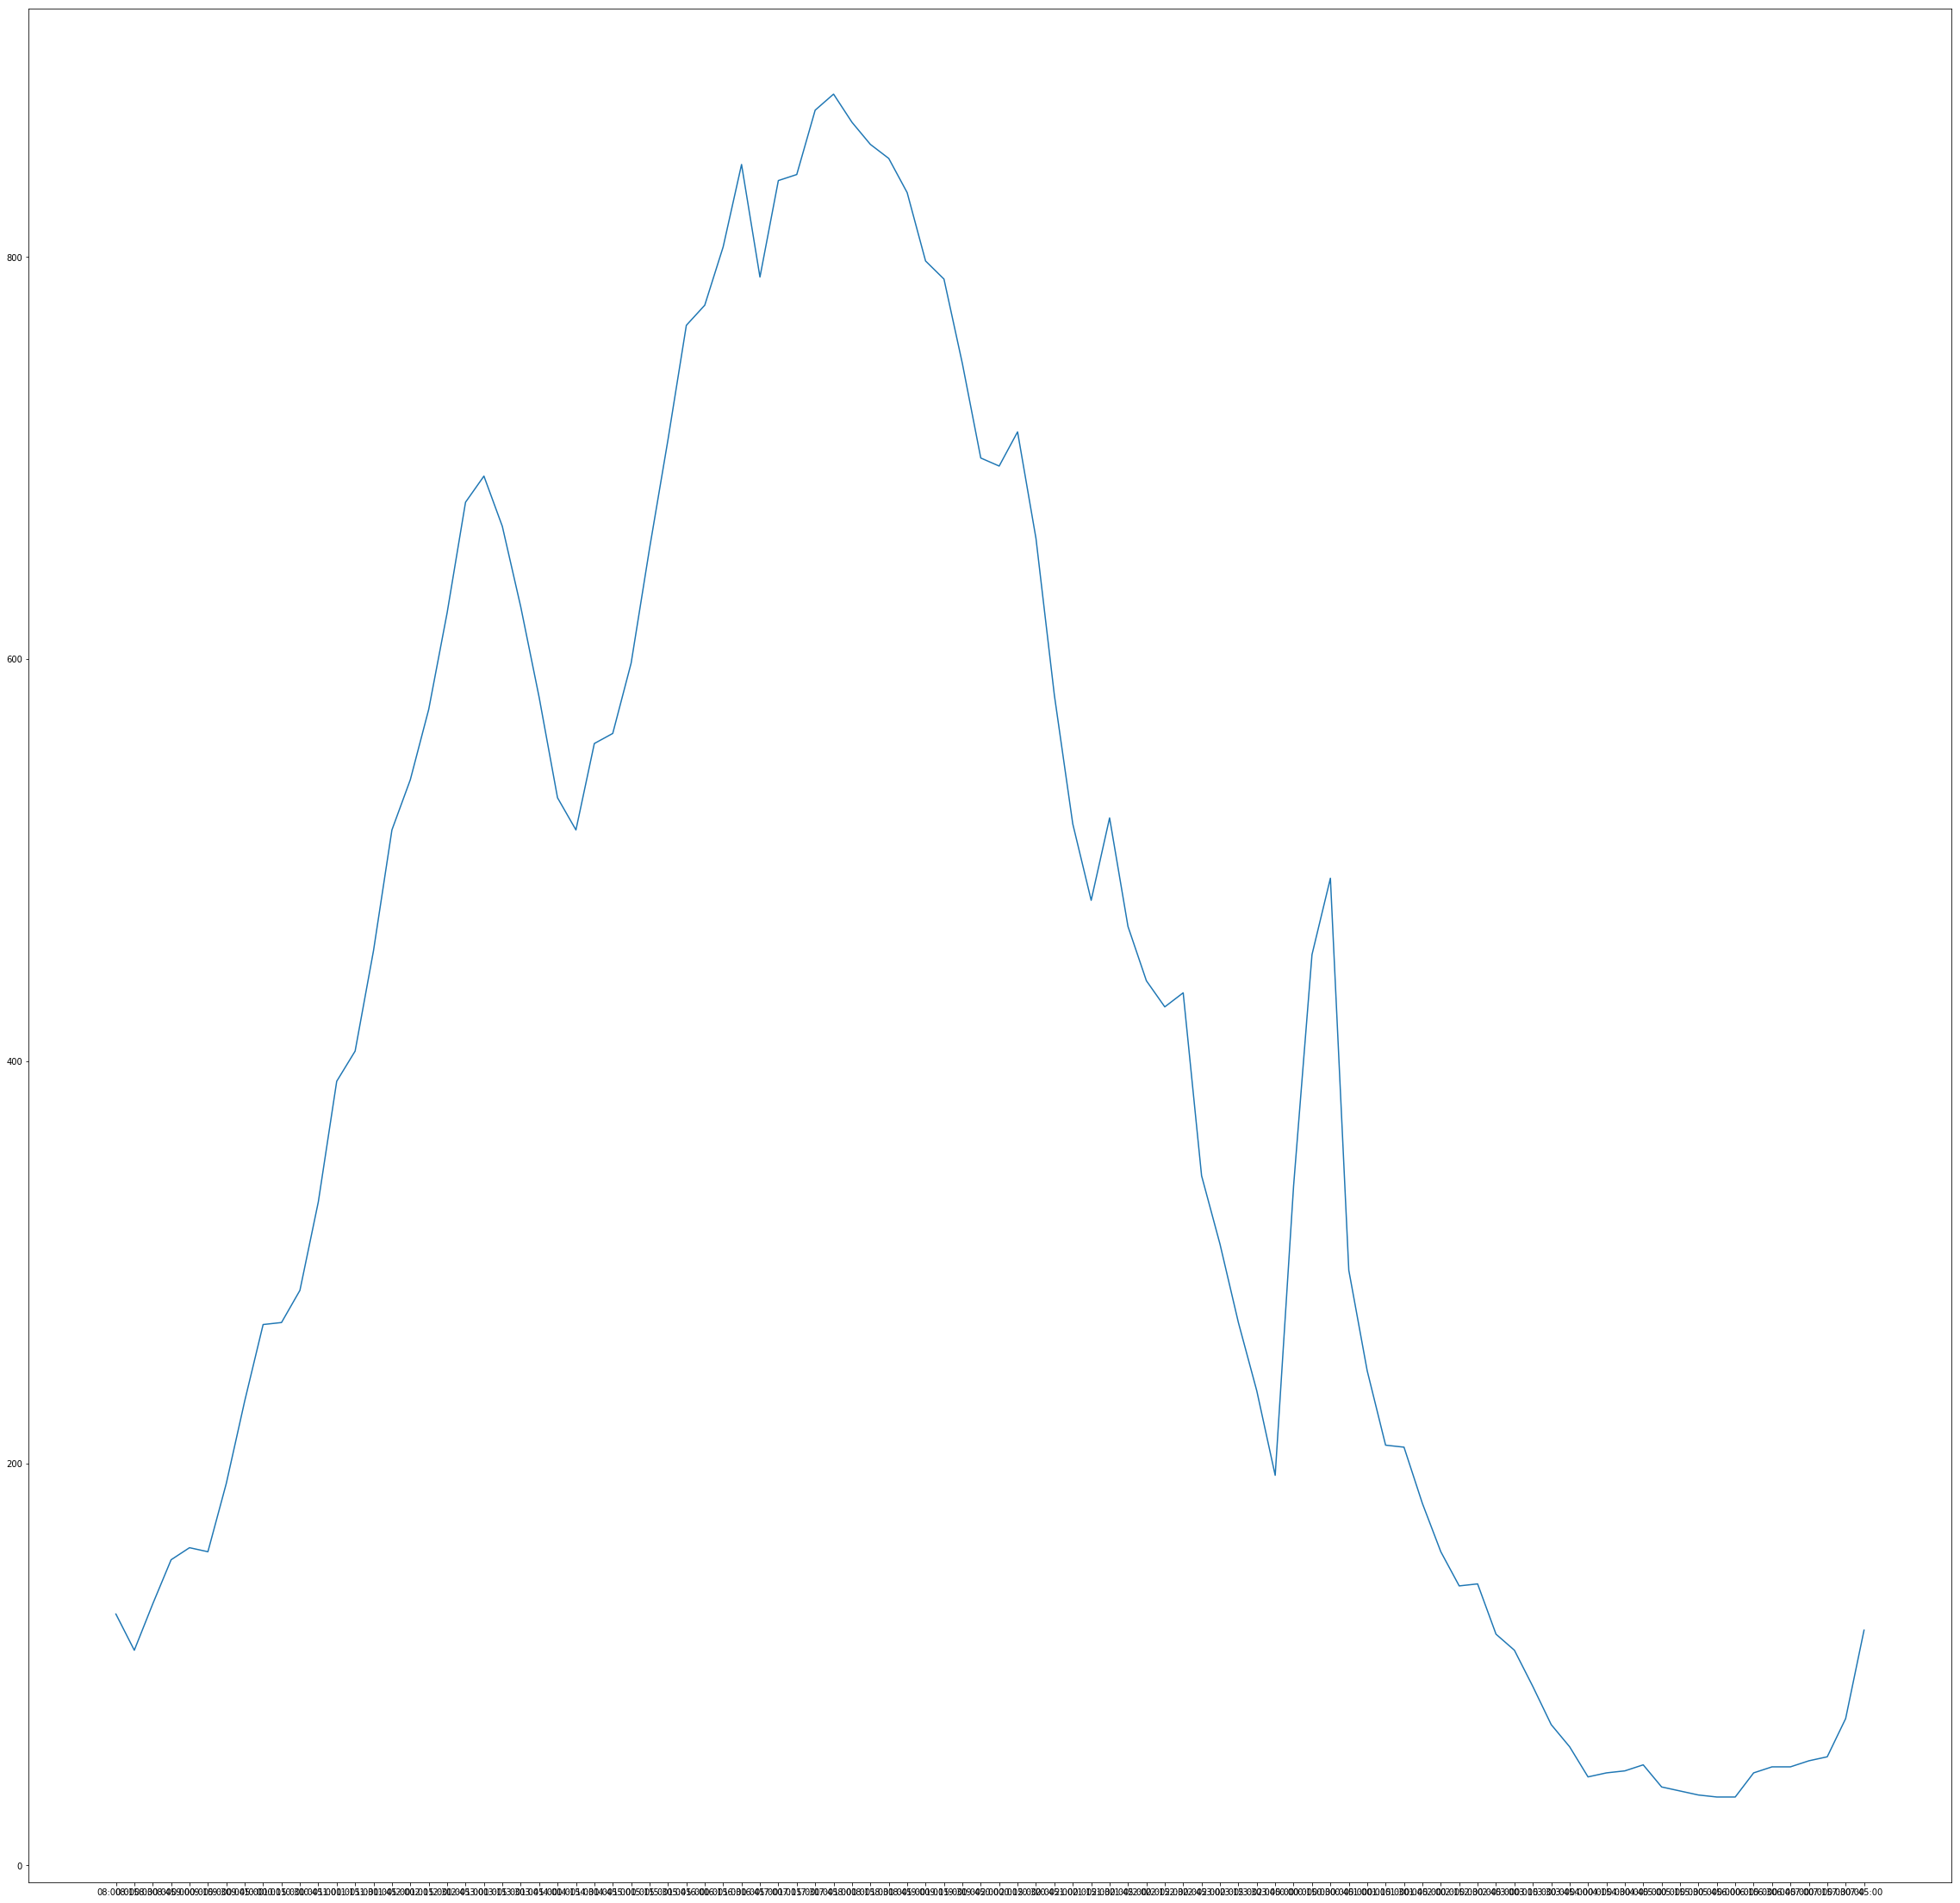

In [68]:
plt.figure(figsize=(40,40))
plt.plot(df_test4.TIME, df_test4.TOTAL_VEHICULOS)
plt.show()

### Generate Dataset by segment

In [5]:
import pandas as pd
df_exp_smooth = pd.read_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\exp_smooth\\ExponentialSmoothing_model.csv', delimiter=';')

In [6]:
df_exp_smooth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163488 entries, 0 to 163487
Data columns (total 5 columns):
TIME               163488 non-null object
ID_SEGMENT         163488 non-null int64
MES                163488 non-null int64
COD_LABORALIDAD    163488 non-null int64
TOTAL_VEHICULOS    163488 non-null int64
dtypes: int64(4), object(1)
memory usage: 6.2+ MB


In [59]:
df_seg = df_exp_smooth.loc[df_exp_smooth['ID_SEGMENT']==17]
df_seg.loc[df_seg.TOTAL_VEHICULOS  < 0, 'TOTAL_VEHICULOS'] = 0
df_seg.to_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\exp_smooth\\segment\\17_exp_smooth.csv', sep=';', index=False)

In [60]:
df_sarimax = pd.read_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\sarimax\\3_Sarimax.csv', delimiter=';')

In [61]:
df_sarimax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Data columns (total 5 columns):
TIME               13440 non-null object
ID_SEGMENT         13440 non-null int64
MES                13440 non-null int64
COD_LABORALIDAD    13440 non-null int64
TOTAL_VEHICULOS    13440 non-null int64
dtypes: int64(4), object(1)
memory usage: 525.1+ KB


In [82]:
df_seg = df_sarimax.loc[df_sarimax['ID_SEGMENT']==20]
df_seg.loc[df_seg.TOTAL_VEHICULOS  < 0, 'TOTAL_VEHICULOS'] = 0
df_seg.to_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\sarimax\\segment\\20_sarimax.csv', sep=';', index=False)

In [83]:
df_fbprophet = pd.read_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\fbprophet\\3_fbprophet.csv', delimiter=';')

In [84]:
df_fbprophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57761 entries, 0 to 57760
Data columns (total 6 columns):
MINUTE             57761 non-null int64
HOUR               57761 non-null int64
ID_SEGMENT         57761 non-null int64
MES                57761 non-null int64
DAY                57761 non-null int64
TOTAL_VEHICULOS    57761 non-null int64
dtypes: int64(6)
memory usage: 2.6 MB


In [105]:
df_seg = df_fbprophet.loc[df_fbprophet['ID_SEGMENT']==21]
df_seg.loc[df_seg.TOTAL_VEHICULOS  < 0, 'TOTAL_VEHICULOS'] = 0
df_seg.to_csv('C:\\Users\\yhoz\\Documents\\dataanalytics.predictive\\models\\01_horus_traffic_prediction\\fbprophet\\segment\\21_fbprophet.csv', sep=';', index=False)

c:\users\yhoz\.conda\envs\predictive.analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
